In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
#from fastai.models.cifar10.resnext import resnext29_8_64
from fastai.metrics import error_rate
import torch
import tarfile
import pickle
import numpy as np
import zipfile

In [3]:
torch.cuda.is_available(),torch.cuda.current_device(),torch.cuda.get_device_name(torch.cuda.current_device())

(True, 0, 'GeForce GTX 1080')

In [9]:
Config.DEFAULT_CONFIG = {
        'data_path': 'd:/.fastai/data',
        'model_path': 'd:/.fastai/models'
    }
Config.create('d:/fastaiconfig.yml')
Config.DEFAULT_CONFIG_PATH = 'd:/fastaiconfig.yml'
path = Config.data_path()/'alienVSpredator'
path.mkdir(parents=True, exist_ok=True)
path

WindowsPath('d:/.fastai/data/alienVSpredator')

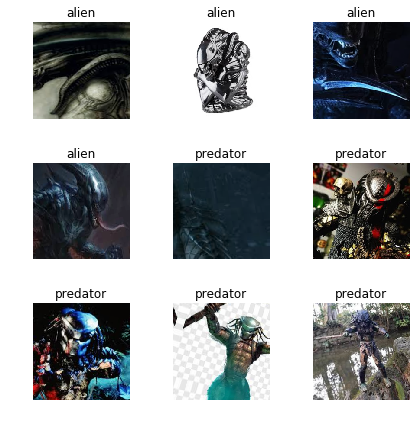

In [10]:
new_path = path/'data'
np.random.seed(1)

tfms = get_transforms(flip_vert = False, max_rotate = 20, p_affine = 1., p_lighting = 1., max_lighting = 0.2, max_zoom = 1.1, max_warp = 0.2)
img_size = 224
bs = 100
data = (ImageList.from_folder(new_path)
        .split_by_folder(valid = 'validation')
        .label_from_folder()
        .transform(tfms, size = img_size)
        .databunch(bs = bs)
        .normalize(imagenet_stats))
data.show_batch(rows = 3, figsize = (6,6))

In [11]:
data.classes, data.c

(['alien', 'predator'], 2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Xiao Zhang/.cache\torch\checkpoints\resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


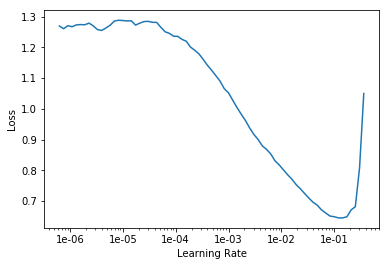

In [12]:
learn = cnn_learner(data, models.resnet34, metrics = accuracy)
gc.collect()
learn.lr_find()
learn.recorder.plot()

In [8]:
data.classes, data.c

(['alien', 'predator'], 2)

In [13]:
learn.fit_one_cycle(8,1e-3, wd = 0.2, div_factor = 6, pct_start = 0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.966160,0.575237,0.750000,01:02
1,0.841487,0.327809,0.885000,01:02
2,0.736856,0.232829,0.905000,01:02
3,0.610115,0.201347,0.925000,01:02
4,0.526063,0.197141,0.900000,01:01
5,0.458070,0.203481,0.920000,01:00
6,0.406433,0.189366,0.920000,01:00
7,0.365713,0.192147,0.930000,00:59


In [14]:
learn.save('stage1')

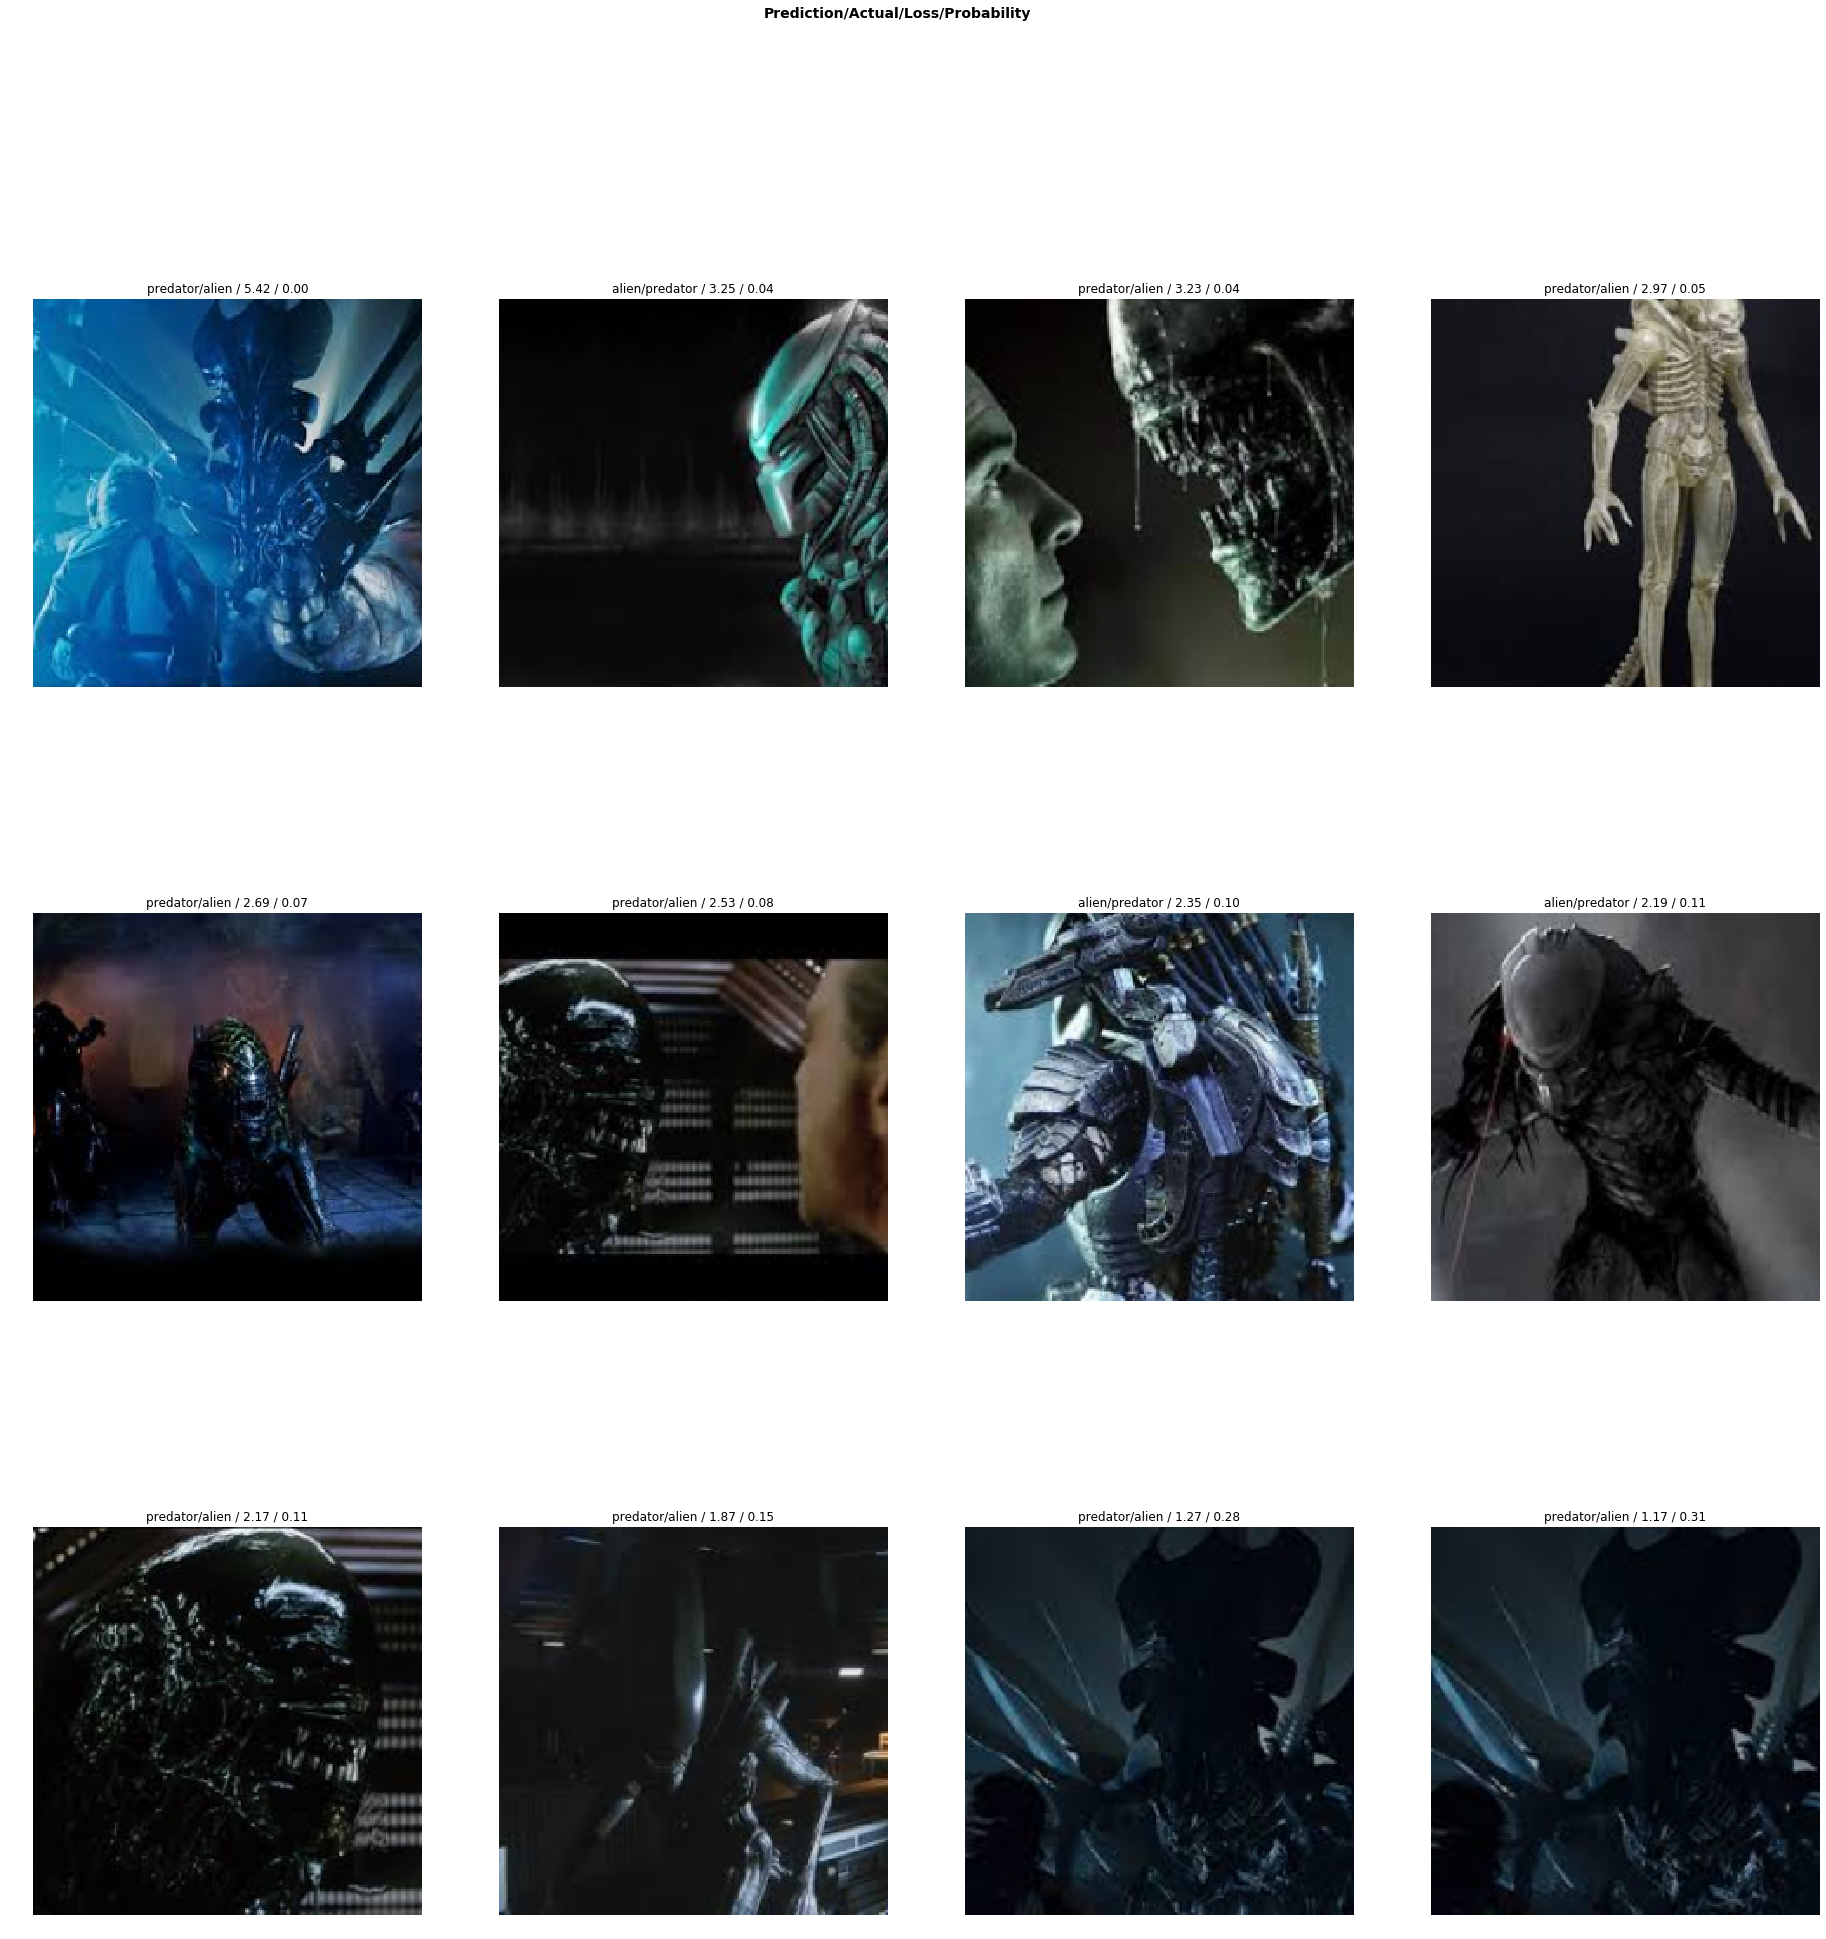

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
losses, ids = interp.top_losses()
len(data.valid_ds) == len(losses) ==len(ids)
interp.plot_top_losses(12, figsize = (32,32))

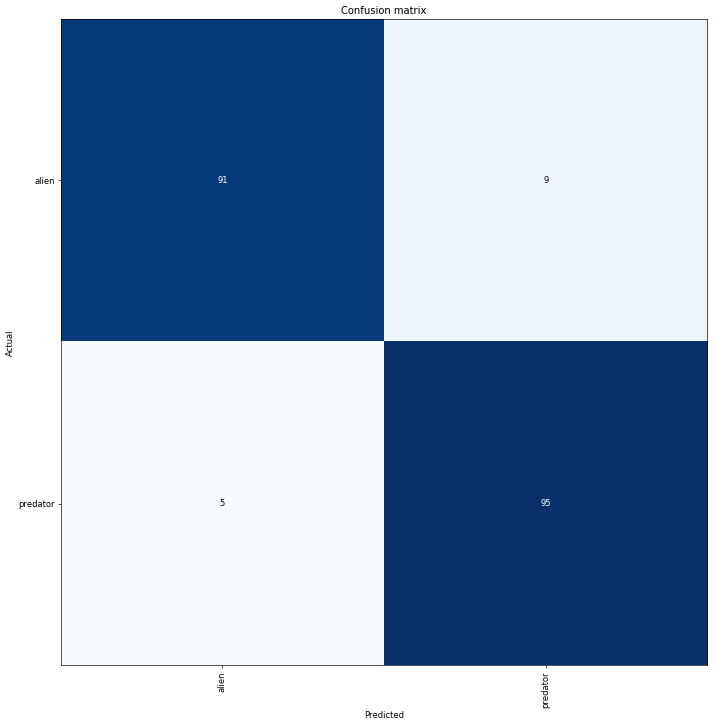

In [16]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


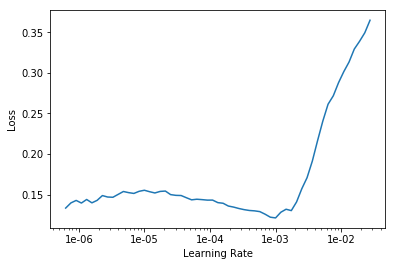

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(8,1e-4, wd = 0.2, div_factor = 5, pct_start = 0.7)

epoch,train_loss,valid_loss,accuracy,time
0,0.163832,0.174741,0.925000,01:01
1,0.152566,0.155004,0.940000,01:01
2,0.139492,0.130310,0.950000,01:00
3,0.121979,0.139590,0.955000,01:00
4,0.106255,0.129303,0.955000,01:01
5,0.090983,0.118087,0.960000,01:01
6,0.077191,0.118099,0.955000,01:01
7,0.068853,0.111335,0.955000,01:01


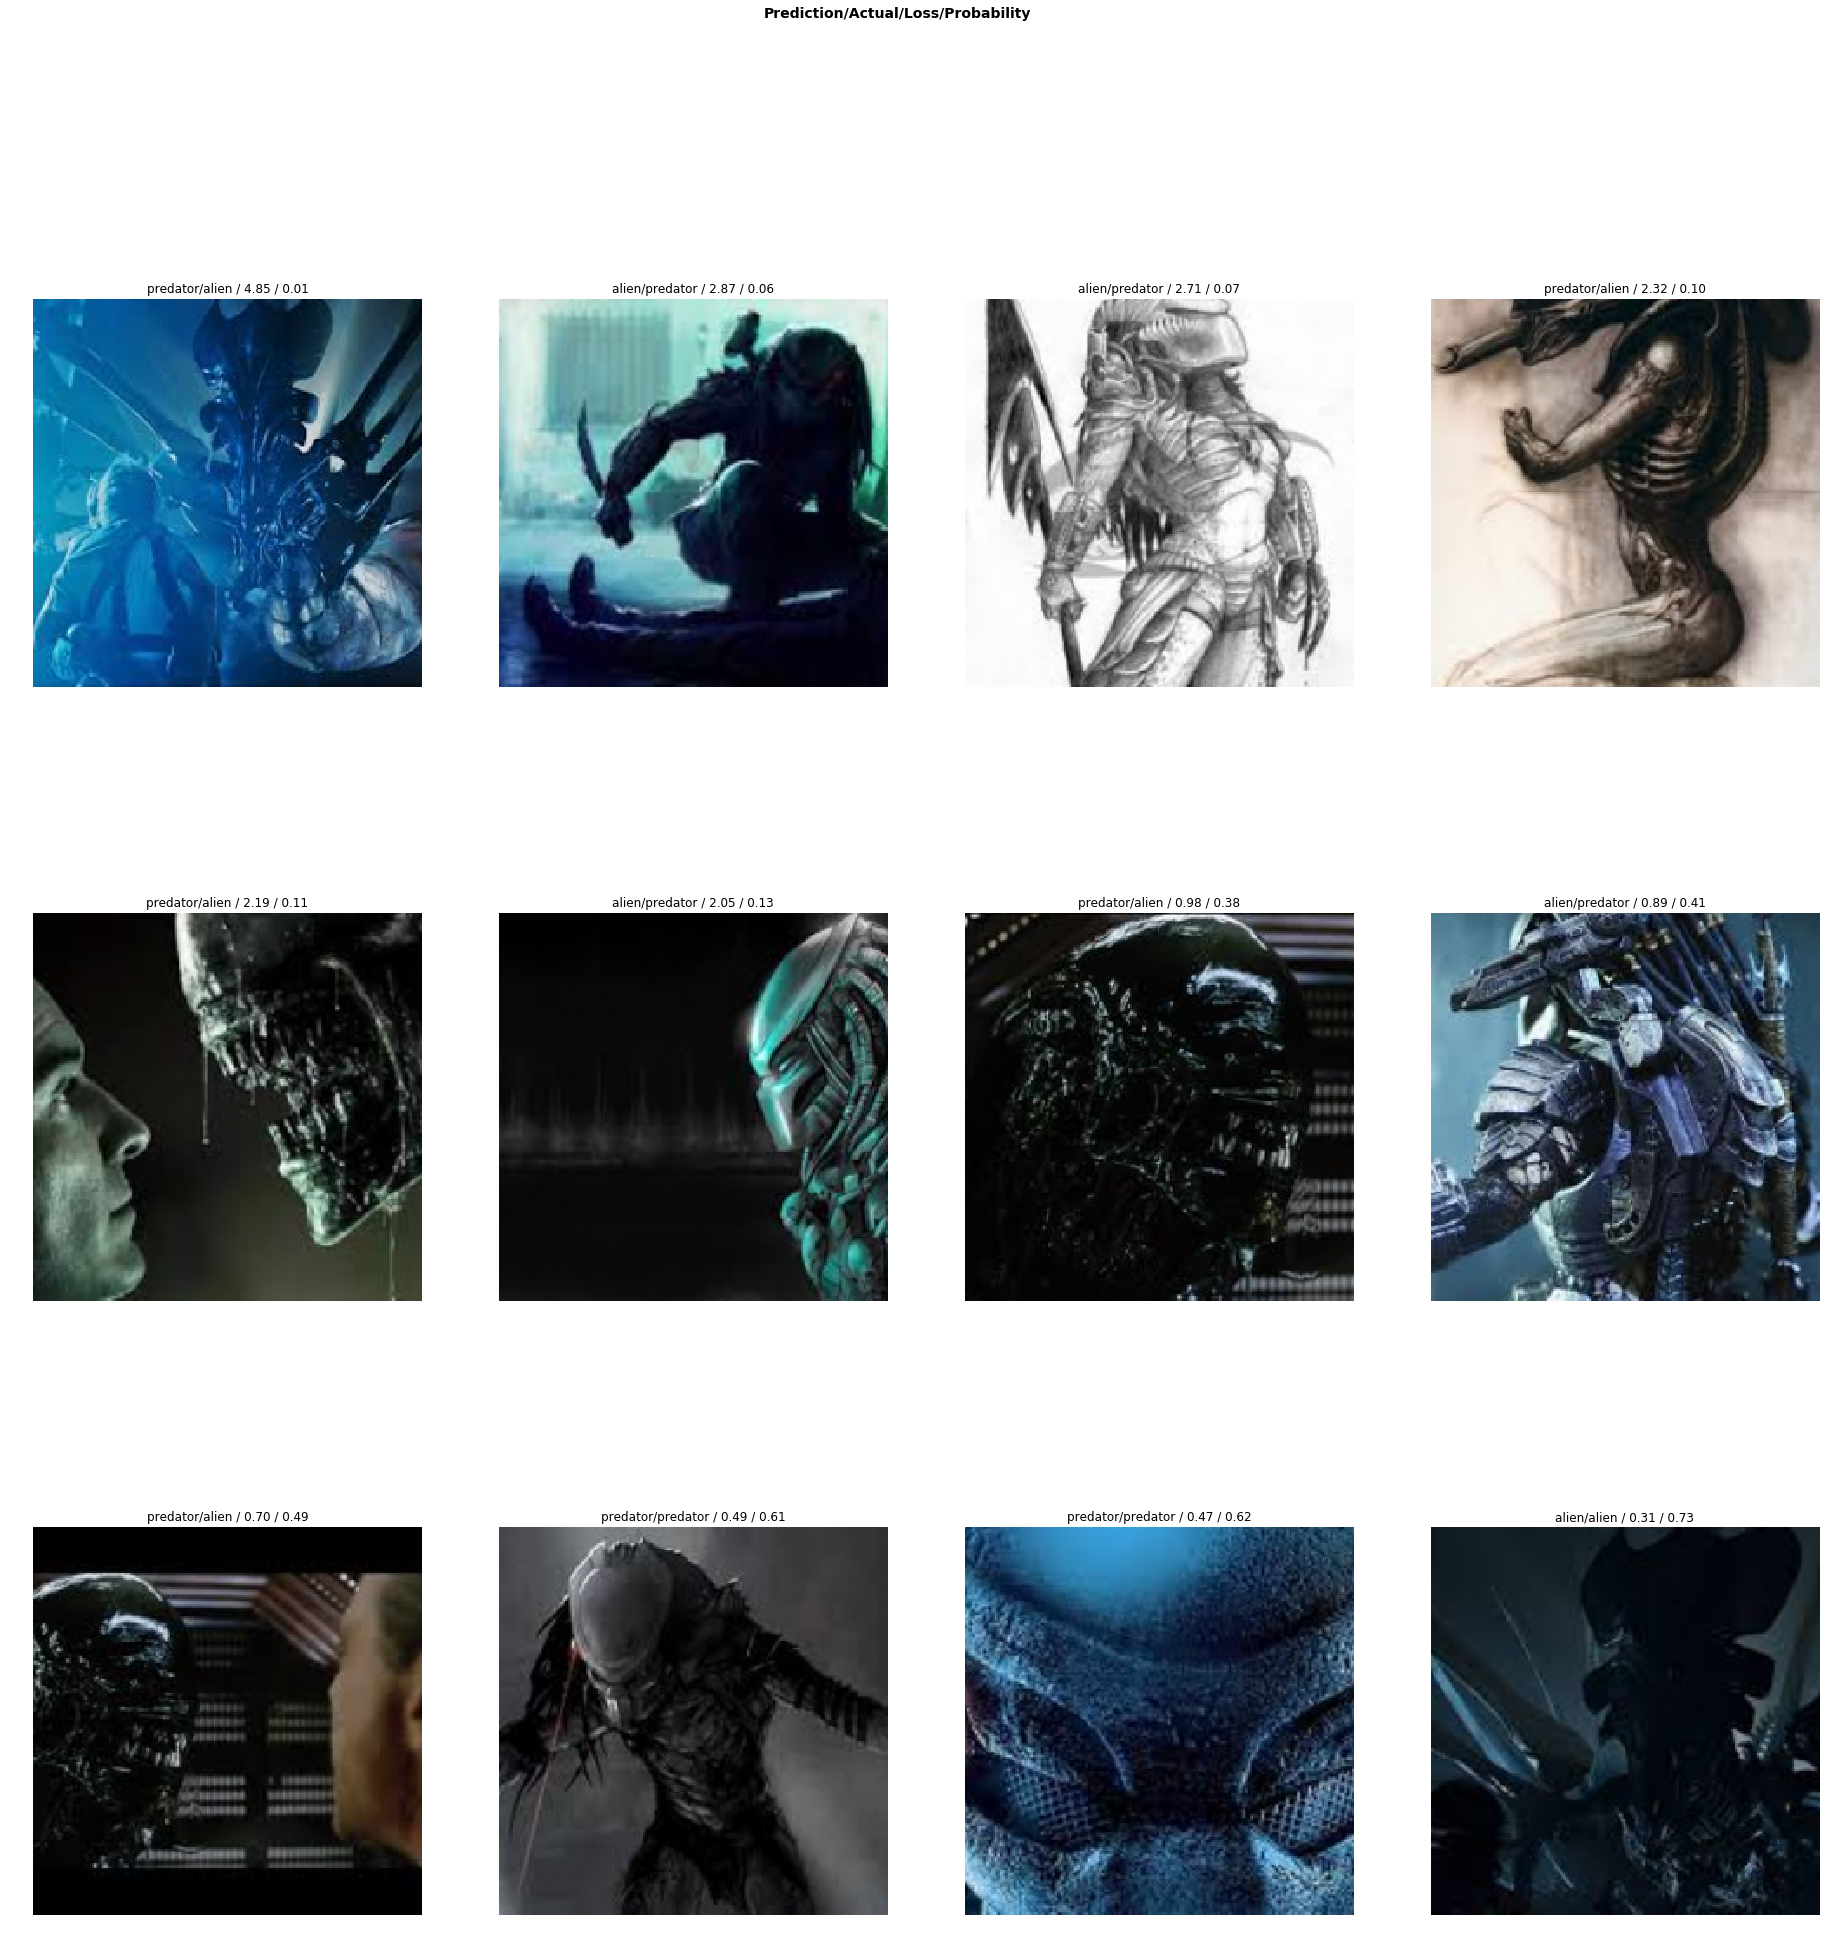

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
losses, ids = interp.top_losses()
len(data.valid_ds) == len(losses) ==len(ids)
interp.plot_top_losses(12, figsize = (32,32))

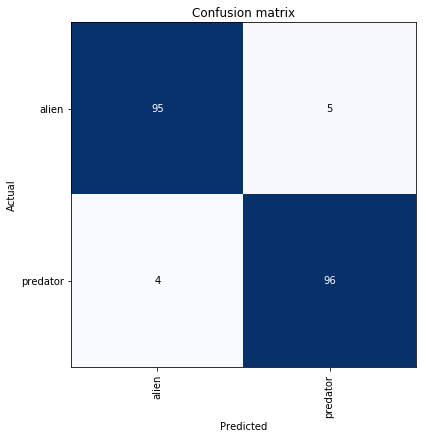

In [26]:
interp.plot_confusion_matrix(figsize=(6,6))

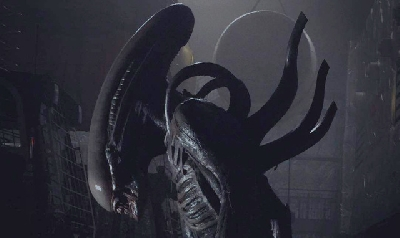

In [20]:
fn = 'D:/.fastai/data/alienVSpredator/data/test1.jpg'
x = open_image(fn);x

In [21]:
pred_class, pred_idx, outputs = learn.predict(x)
pred_class, pred_idx, outputs

(Category alien, tensor(0), tensor([1.0000e+00, 4.2309e-07]))